In [1]:
import sys
import os
_path = os.path.abspath('../')
if _path not in sys.path:
    sys.path.insert(0, _path)
print('done adding path')
    
import astropy.coordinates as coord
import numpy as np
from gala.units import UnitSystem
from yellowcard.model import TimingArgumentModel 
from yellowcard.coordinates import fiducial_m31_c,LocalGroupHalocentric
import astropy.units as u
from scipy.optimize import minimize
from yellowcard.keplerianPlane import LGKepler
from numpy.linalg import norm
import emcee
import arviz as az
from schwimmbad import MultiPool 
import warnings
warnings.filterwarnings('ignore')
import corner

import matplotlib.pyplot as plt


done adding path


In [2]:
# modelChoice = "vdm2012-radial"
# modelChoice = "vdm2012"
# modelChoice = "fiducial2021"
modelChoice = "apw-simulated"
# modelChoice = "apw-simulated-precise"

In [3]:
model = TimingArgumentModel.from_dataset(f"../datasets/{modelChoice}.ecsv")

In [4]:
galcen_m31     = fiducial_m31_c.transform_to(model.galcen_frame)
galcen_m31_pos = galcen_m31.data.without_differentials()
galcen_m31_vel = galcen_m31.velocity
galcen_m31_L   = galcen_m31_pos.cross(galcen_m31_vel)
galcen_m31_L   = galcen_m31_L / galcen_m31_L.norm()

In [5]:
# e_init   = 0.9
# eta_init = 5*u.rad
# alpha_init = 0*u.rad
# init_par = {}

# init_par['lnr'] = np.log(fiducial_m31_c.distance.value)
# init_par['eParam'] = -3
# init_par['coseta'] = np.cos(eta_init)
# init_par['sineta'] = np.sin(eta_init)
# init_par['lnM'] = np.log((4e12*u.Msun).decompose(model.unit_system).value)
# init_par['cosalpha'] = np.cos(alpha_init)
# init_par['sinalpha'] = np.sin(alpha_init)

In [6]:
init_par = {
    'lnr': np.log(711.91702),
    'lnM': np.log(3.8),
    'coseta': np.cos(4.3),
    'sineta': np.sin(4.3),
    'tperi': 14.524635,
    'cosalpha': np.cos(0.56548),
    'sinalpha': np.sin(0.56548),
    'eParam': np.log(1 - 0.981),
}

In [7]:
model.ln_posterior(init_par)

(-8.196899784882483,
 [-117.99130035398723,
  25.469820115388547,
  182.90067734462548,
  707.9761751602273])

In [8]:
alphas = np.linspace(0, 4*np.pi, 128)
vals = []
for alp in alphas:
    pp = init_par.copy()
    pp['cosalpha'] = np.cos(alp)
    pp['sinalpha'] = np.sin(alp)
    vals.append(model.ln_posterior(pp)[0])

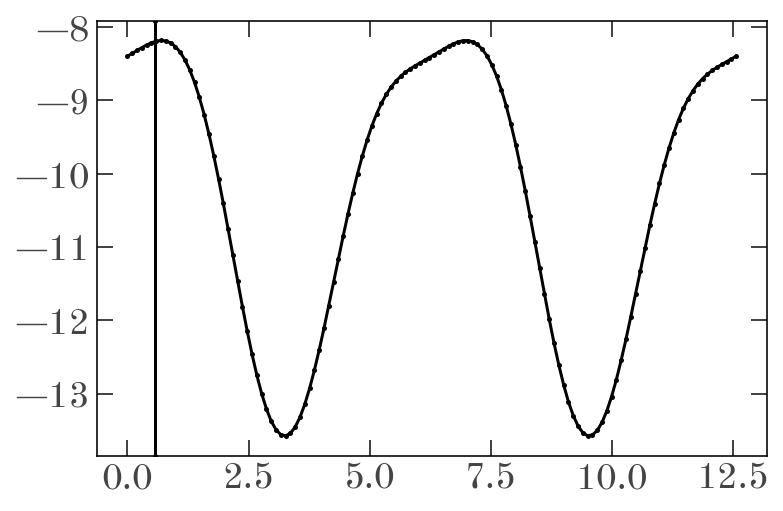

In [9]:
plt.plot(alphas, vals)
plt.axvline(0.56)

---
## creating first minimization of MCMC 

In [10]:
result = minimize( lambda *args: -model(*args)[0], model.pack_pars(init_par), method='Powell')
# result

In [11]:
result

   direc: array([[ 1.43852131e-03, -2.70419036e-01, -1.15206932e-03,
         2.13464969e-03, -1.71239009e-03, -9.50056633e-02,
        -9.94521168e-02],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
         0.00000000e+00],
       [ 2.37284246e-05,  3.42427720e-04, -3.33734743e-05,
        -8.24509265e-06, -4.74667335e-06, -4.93495489e-04,
        

In [12]:
model.transform_pars(model.unpack_pars(result.x))

{'r': 715.0179854940686,
 'e': 0.9884432589278491,
 'eta': 4.280491691230518,
 'M': 3.769544089140254,
 'alpha': 0.43054153858044836}

____
# MCMC

In [12]:
nwalkers = 8*len(result.x)
sampler_x0 = np.random.normal(result.x, 1e-1, size=(nwalkers,len(result.x)))

In [ ]:
with MultiPool() as pool:
    sampler = emcee.EnsembleSampler(nwalkers=nwalkers, 
                                    ndim=len(result.x), 
                                    log_prob_fn=model, 
                                    pool=pool,
                                    blobs_dtype=model.blobs_dtype)

    # burn in #1
    state = sampler.run_mcmc(sampler_x0, 
                     nsteps=1000, 
                     progress=True)  # burn in
#     chain_meds = np.median(sampler.chain[:, -1],
#                            axis=0)
#     new_x0s = np.random.normal(chain_meds, 1e-2, size=(nwalkers, len(result.x)))
#     sampler.reset()
# #     print("done with first burn in")
    
#     # burn in #2 
#     state = sampler.run_mcmc(new_x0s, 
#                              nsteps=1000,
#                              progress=True)
    sampler.reset()
#     print("done with second burn in")
    
    # main mcmc run
    state = sampler.run_mcmc(state, 
                             nsteps=2000, 
                             progress=True)
#     print("done with chain")

 88%|████████▊ | 877/1000 [01:52<00:16,  7.47it/s]

----
## creating list of means of each parameter

In [ ]:
everyHundo = np.vstack(sampler.chain[:, ::100])
allOfThem = np.vstack(sampler.chain[:, ::])

subsample = {}
sample = {}
col_names = ["lnr","eParam", "coseta", "sineta", "lnM", "cosalpha", "sinalpha"]
for i in range(len(col_names)):
    subsample[col_names[i]] = everyHundo[:,i]
    sample[col_names[i]] = allOfThem[:,i]
    
model_params = np.vstack([model.transform_pars(sample)[key] for key, values in model.transform_pars(sample).items()]).T
model_params_subsample = np.vstack([model.transform_pars(subsample)[key] for key, values in model.transform_pars(subsample).items()]).T

means = {}
for key, values in model.transform_pars(sample).items():
    means[key] = np.mean(model.transform_pars(sample)[key]) 
means

In [ ]:
everyHundo = np.vstack(sampler.chain[:, ::100])
allOfThem = np.vstack(sampler.chain[:, ::])
blobs = sampler.get_blobs()

subsample = {}
sample = {}
blobSample = {}
col_names = ["lnr","eParam", "coseta", "sineta", "lnM", "cosalpha", "sinalpha"]
for i in range(len(col_names)):
    subsample[col_names[i]] = everyHundo[:,i]
    sample[col_names[i]] = allOfThem[:,i]

for i in blobs.dtype.names:
    blobSample[i] = blobs[i].flatten()
    
model_params = np.vstack([model.transform_pars(sample)[key] for key, values in model.transform_pars(sample).items()]+
                        [blobSample[key] for key, values in blobSample.items()]).T

means = {}
for key, values in model.transform_pars(sample).items():
    means[key] = np.mean(model.transform_pars(sample)[key]) 
means

In [ ]:
sample['lnr']

In [ ]:
model_params.shape

In [ ]:
blobSample.items()

In [ ]:
np.median(model.transform_pars(subsample)['r'])

In [ ]:
np.median(model.transform_pars(subsample)['M'])

---
## figures for full sampled set of data

In [ ]:
tulips = az.from_emcee(sampler,
                       var_names=["ln r","ln(1-e)", "coseta", "sineta", "ln M", "cosalpha", "sinalpha"])
lookout = az.convert_to_inference_data(model.transform_pars(sample))
looks = az.convert_to_dataset(lookout).to_array()

In [ ]:
fig = az.plot_trace(tulips);
# fig.suptitle(model.title,fontsize=20)
plt.savefig(f"../plots/{modelChoice}-trace.png")

az.plot_pair(tulips);


In [ ]:
fig = corner.corner(np.vstack(sampler.chain[:, ::]),
                    labels=["ln r","ln(1-e)", "coseta", "sineta", "ln M", "cosalpha", "sinalpha"],
                    show_titles=True)
ii = 0
fig.text(0.8, 0.63,"Means",fontsize=20)
for key, val in means.items():
    try:
        val = val.value
    except AttributeError:
        val = val
    fig.text(0.8,0.6-0.02*ii,key+"=%.2f" % val,fontsize=20)
    ii+=1
fig.suptitle(model.title,fontsize=20)
plt.savefig(f"../plots/{modelChoice}-parametrizedCorner.png")
plt.show()

In [ ]:
truths = {
    'r': 711.91702,
    'M': 3.8,
    'eta': 4.3,
    'tperi': 14.524635,
    'alpha': 0.56548,
    'e': 0.981,
    'a': 511,
    'vscale': 182.9,
    'vrad': -118,
    'vtan': 25.47,
    'sunToM31': 707.9769
}

fig = corner.corner(model_params,
                    labels=["r","e", "eta", "M", "alpha","vrad","vtan","vscale","sunToM31"],
#                     truths=truths,
                    show_titles=True);
# ii = 0
# fig.text(0.8, 0.63,"Means",fontsize=20)
# for key, val in means.items():
#     try:
#         val = val.value
#         val = val
#     fig.text(0.8,0.6-0.02*ii,key+"=%.2f" % val,fontsize=20)
#     ii+=1
fig.suptitle(model.title,fontsize=20)
plt.savefig(f"../plots/{modelChoice}-modelCorner.png",transparent=False,facecolor="white")
plt.show()

___
## the plots below are for the transformed variables

In [ ]:
az.plot_trace(lookout);
az.plot_pair(lookout);

In [ ]:
blobs = sampler.get_blobs()
plt.hist(np.ravel(blobs['sunToM31'][::10]),20)
plt.show()


In [ ]:
blobs.dtype.names[0]

In [ ]:
# plt.hist2d(np.ravel(blobs['sunToM31'][::10]), model.whats_this(lil)['r'],bins=64)
# plt.show()

----
## some extra testing stuff

In [ ]:
# corner.corner(model_params,
#               labels=["r","e", "eta", "M", "alpha"],
#               show_titles=True);

In [ ]:
# meanies = np.mean(np.vstack(sampler.chain[:, ::100]), axis=0)
# whats_this_mean(model.unpack_pars(meanies))

In [ ]:
# whats_this(par_dict)

In [ ]:
# # def whats_this_mean(par_dict):
# #         ''' you can tell that i hard coded this function :) '''
# #         what_dict = {}
# #         what_dict['r'] = np.mean(np.exp(par_dict['lnr']))*u.kpc
# #         what_dict['e'] = np.mean(1 - np.exp(par_dict['eParam']))
# #         etta = np.arctan2(par_dict['sineta'],par_dict['coseta']) # *u.rad
# #         what_dict['eta'] = np.mean(etta%(2*np.pi))
# #         what_dict['M'] = np.mean(np.exp(par_dict['lnM'])*model.unit_system['mass'])
# #         allpha = np.arctan2(par_dict['sinalpha'],par_dict['cosalpha']) # *u.rad
# #         what_dict['alpha'] = np.mean(allpha%(2*np.pi))
# #         return what_dict



# def whats_this(par_dict):
#         ''' you can tell that i hard coded this function :) '''
#         what_dict = {}
#         what_dict['r'] = np.exp(par_dict['lnr'])
#         what_dict['e'] = 1 - np.exp(par_dict['eParam'])
#         etta = np.arctan2(par_dict['sineta'],par_dict['coseta']) # *u.rad
#         what_dict['eta'] = etta%(2*np.pi)
#         what_dict['M'] = np.exp(par_dict['lnM'])
#         allpha = np.arctan2(par_dict['sinalpha'],par_dict['cosalpha']) # *u.rad
#         what_dict['alpha'] = allpha%(2*np.pi)
#         return what_dict

In [ ]:
# lil

In [ ]:
# whats_this(lil)

In [ ]:
# last_pars = model.unpack_pars(sampler.chain[:, -1].T)
# last_Lhatlg = coord.CartesianRepresentation(last_pars['Lhatlg'])
# last_Lhatlg_sph = last_Lhatlg.represent_as(coord.UnitSphericalRepresentation)
# plt.scatter(last_Lhatlg_sph.lon, last_Lhatlg_sph.lat)
# plt.xlim(0, 2*np.pi)
# plt.ylim(-np.pi, np.pi)